# HyNet

In this notebook, we create a dataset of Armenian characters using the font Mk_Parz_U, and train a convolutional neural network to recognize characters from 56x56 images.

## Prepare

We build a dataset of Armenian characters based on the font Mk_Parz_U-Italic which resembles the one used in our target document :

![Document](test/samples/sample_denoised.png)

We use 56x56 pixel images and use filters and transformations to get a total of 34200 samples. We then split between train and test dataset with a ratio of 80/20.

In [9]:
import os
import pickle

from hynet.prepare import generate_classes, generate_dataset

N = 56  # 56x56 pixels
font_names = ["hynet/fonts/Mk_Parz_U-Italic"]
nb_classes = len(generate_classes())
train_dataset, test_dataset = generate_dataset(
    font_names=font_names, N=N, split_ratio=0.8
)

path = R"build/datasets/hynet"
os.makedirs(path, exist_ok=True)
train_dataset = pickle.load(open(os.path.join(path, "train_dataset.pkl"), "rb"))
test_dataset = pickle.load(open(os.path.join(path, "test_dataset.pkl"), "rb"))
with open(os.path.join(path, "train_dataset.pkl"), "wb") as f:
    pickle.dump(train_dataset, f)
with open(os.path.join(path, "test_dataset.pkl"), "wb") as f:
    pickle.dump(test_dataset, f)

2023-10-20 01:30:58,959 - root - INFO - Characters used     : ԱԲԳԴԵԶԷԸԹԺԻԼԽԾԿՀՁՂՃՄՅՆՇՈՉՊՋՌՍՎՏՐՑՒՓՔՕՖաբգդեզէըթժիլխծկհձղճմյնշոչպջռսվտրցւփքօֆ
2023-10-20 01:30:58,960 - root - INFO - Number of classes   : 76
2023-10-20 01:30:58,961 - root - INFO - Data augmentation   : 1 fonts, 20 rotations, 20 blur radiuses, 3 mode filters, 1 noise intensities
2023-10-20 01:30:58,961 - root - INFO - Number of samples   : 91200


## Train

We train our LeNet-5 model to categorize the images into our 76 classes (alphabet with caps and small letters).

In [37]:
import os
import pickle

import torchvision.transforms as transforms
from hynet.model import LeNet
from hynet.train import train
from torch.utils.data import DataLoader

batch_size = 16
nb_epochs = 10
learning_rate = 3.0e-4
steplr_step_size = 20
early_stopping_patience = 3

path = R"build/datasets/hynet"

train_dataset = pickle.load(open(os.path.join(path, "train_dataset.pkl"), "rb"))
train_data = next(iter(train_dataset))
mean, std = train_data[0].mean(), train_data[0].std()
test_dataset = pickle.load(open(os.path.join(path, "test_dataset.pkl"), "rb"))
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, drop_last=True
)
test_dataloader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, drop_last=True
)

# Initialize model
model_name = "LeNet-5"
model = LeNet(N=N, C=int(nb_classes), mean=mean, std=mean)

# Train
report = train(
    model_name=model_name,
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    nb_classes=int(nb_classes),
    batch_size=batch_size,
    nb_epochs=nb_epochs,
    init_learning_rate=learning_rate,
    steplr_step_size=steplr_step_size,
    early_stopping_patience=early_stopping_patience,
)

2023-10-20 01:40:41,088 - root - INFO - Epoch = 1 / 10, Training Loss = 0.21, Test Loss = 0.21, Test Accuracy = 97.98%
2023-10-20 01:41:34,139 - root - INFO - Epoch = 2 / 10, Training Loss = 0.21, Test Loss = 0.21, Test Accuracy = 99.51%
2023-10-20 01:42:28,971 - root - INFO - Epoch = 3 / 10, Training Loss = 0.21, Test Loss = 0.21, Test Accuracy = 99.51%
2023-10-20 01:43:23,871 - root - INFO - Epoch = 4 / 10, Training Loss = 0.21, Test Loss = 0.21, Test Accuracy = 99.51%


In [3]:
nb_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Nb of model parameters : {nb_parameters}")

Nb of model parameters : 251636


## Export

We export our trained model to various targets.

(<Figure size 800x500 with 2 Axes>,
 array([<Axes: title={'center': 'Loss'}, xlabel='epoch'>,
        <Axes: title={'center': 'Accuracy'}, xlabel='epoch'>], dtype=object))

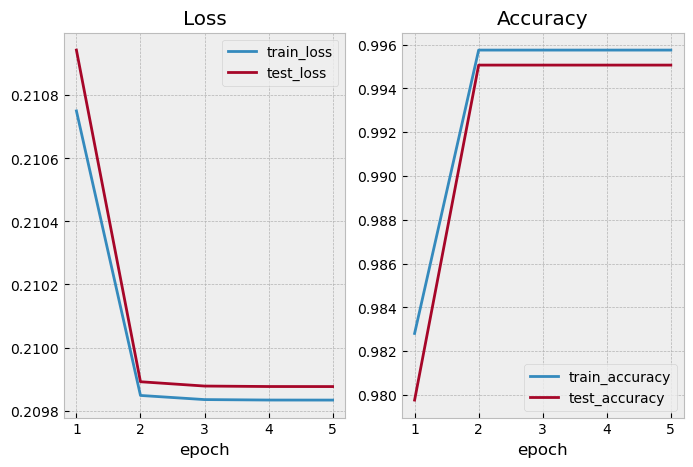

In [ ]:
train_folder = "build/logs/train"
os.makedirs(train_folder, exist_ok=True)
report.save_model(os.path.join(train_folder, "model.pt"))  # save model
report.save_fig(os.path.join(train_folder, "report.svg"))  # plot report as png
report.to_csv(os.path.join(train_folder, "report.csv"))  # export full report
report.plot()

## Evaluation

We evaluate our model on the first batch and then show miscategorized samples.

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from hynet.prepare import generate_classes
from PIL import Image, ImageFont

nb_batches = 10

df = report.dataframe
classes = generate_classes()

records = []
with torch.no_grad():
    for i, (inputs, labels) in enumerate(train_dataloader):
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        for j, (T, label) in enumerate(zip(inputs, labels)):
            prediction = classes[predicted[j].item()]
            expected = classes[label.item()]
            if prediction != expected:
                records.append({"prediction": prediction, "expected": expected})
result = pd.DataFrame(records)

In [6]:
# Print most frequent miscategorized labels
result.apply(lambda x: f"{x['prediction']} => {x['expected']}", axis=1).value_counts()

ր => ը    310
Name: count, dtype: int64

In [36]:
from hynet.prepare import generate_character_image, generate_classes

torch.manual_seed(1337)
font_name = "Mk_Parz_U-Italic"
#font_name = "Mk_Parz_U"
#font_name = "arial"
# font_name = "Arm Hmk's Bebas Neue"
font = ImageFont.truetype(f"./hynet/fonts/{font_name}.ttf", N)

correct_predictions, total_predictions = 0, 0
records = []
model.eval()
with torch.no_grad():
    for i, character in enumerate(classes):
        T = generate_character_image(character, font, N)
        outputs = model(T.view(1, 1, N, N))
        _, predicted = torch.max(outputs, 1)
        correct_predictions += 1 if (predicted.item() == i) else 0
        total_predictions += 1
        predictions = {
            classes[i]: prediction for (i, prediction) in enumerate(outputs[0])
        }
        for predicted_character, probability in predictions.items():
            records.append(
                {
                    "character": character,
                    "predicted_character": predicted_character,
                    "probability": probability.item(),
                }
            )
model.train()
df = pd.DataFrame.from_records(records)
print(correct_predictions, total_predictions, correct_predictions / total_predictions)

76 76 1.0


Ա 1.0347887524631005e-07
Բ 2.835290331404394e-07
Գ 4.6867197622812995e-12
Դ 4.881546722401708e-09
Ե 1.2611935744644143e-06
Զ 2.8623277081862852e-09
Է 1.6914643907739446e-08
Ը 1.58924379434211e-07
Թ 2.0274280032595016e-08
Ժ 2.4133637310796985e-08
Ի 7.460999285058278e-08
Լ 7.641541621694614e-09
Խ 4.4775405605435026e-10
Ծ 2.14176552049139e-07
Կ 1.0943680406327871e-09
Հ 1.3960184570838141e-11
Ձ 4.630084315948579e-09
Ղ 1.1691451362594307e-08
Ճ 3.958063210518503e-09
Մ 1.0898593671981871e-07
Յ 8.452781807832821e-10
Ն 1.0388615523382327e-09
Շ 4.518955392995849e-06
Ո 3.4904957146864035e-08
Չ 2.445871594147775e-08
Պ 3.52754409016498e-10
Ջ 5.882608289375924e-10
Ռ 3.882116317299733e-08
Ս 1.3940962162450887e-07
Վ 2.95447382114844e-08
Տ 9.130053935102467e-10
Ր 4.8372637451166156e-08
Ց 5.505815181550133e-08
Ւ 1.7173166497741477e-06
Փ 1.1064621219247783e-08
Ք 8.889011304802352e-09
Օ 7.61208429622684e-09
Ֆ 1.2077473243721215e-08
ա 7.161506387909355e-10
բ 3.062893256355892e-06
գ 1.0751217871529661e-07
դ

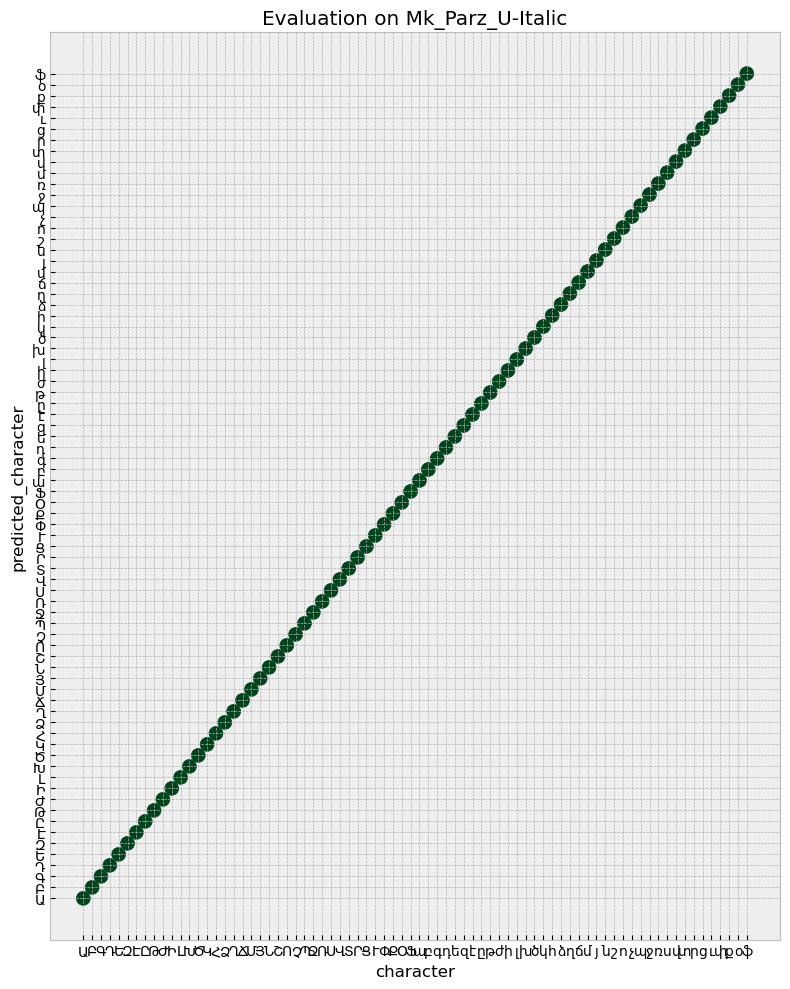

In [35]:
import matplotlib.style as style

style.use("bmh")
fig, ax = plt.subplots(figsize=(8, 10))
pos = df.plot.scatter(
    x="character",
    y="predicted_character",
    c=df["probability"] * 100,
    s=df["probability"] * 100.0,
    ax=ax,
    title=f"Evaluation on {font_name}",
    colorbar=False,
    colormap="BuGn",
)
plt.tight_layout()
plt.savefig(
    Rf"C:\Users\Romain\OneDrive\Documents\Repos\v4nn4.github.io\assets\images\evaluation_{font_name}.png"
)
for _, _, x, v in df[df["character"]=="ր"].to_records():
    print(x, v)